In [11]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [12]:
%matplotlib inline

Try to mask out HUD/UI elements by detection regions that slowly change from frame to frame

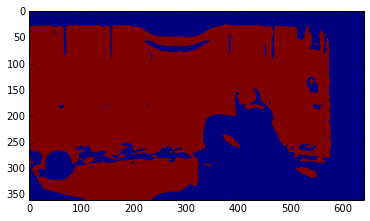

In [162]:
images = array(images)
diffs = images[1:] - images[:-1]
mask = std(diffs, 0)
thresh = 0.3;
mask = cv2.GaussianBlur(mask, (0,0), 2)
mask[mask < mask.max() * thresh] = 0
mask[mask >= mask.max() * thresh] = 1

imshow(mask)

In [128]:
import cv2

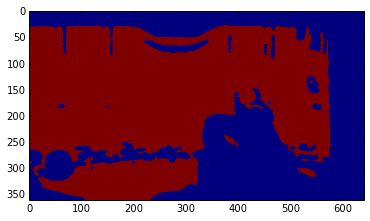

In [190]:
mask2 = cv2.medianBlur(array(mask, dtype=np.float32), 5)
mask2 = cv2.erode(mask2, ones((3,3)))
imshow(mask2)

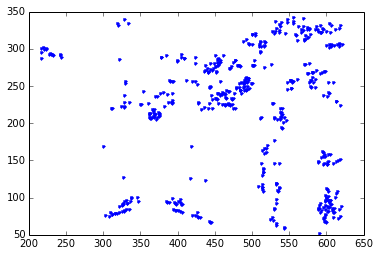

In [395]:
plot(points[:, 0], points[:, 1], '.')